In [1]:
import numpy as np
import matplotlib.pyplot as plt
import examples
import warnings
warnings.filterwarnings('ignore')

# Advanced Chemistry Practical: Computational Chemistry

Welcome to the advanced pratical focusing on [computational chemistry](./README.md). Over the next four weeks you will: 

- gain a understanding of, and familiarity, with molecular dynamics (MD) simulations.
- learn how MD simulations are performed in practice.
- use MD simulations to study the solid state materials, such as batteries and solar cells. 
- rationalise your results in terms of physical chemistry phenomena you are familiar with. 

For more details about the learning objectives of this practical, please see the [lesson plan](https://github.com/symmy596/Advanced_Practical_Chemistry_Teaching/blob/master/LESSONPLAN.md) online. 

This pratical will also make use of some of the **Python** and **Jupyter** skills that you were introduced to in the first and second year computational laboratory, if you feel that these are not fresh in your mind it might be worth looking back at the exercises from previous years, or investigate the links provided in this document.

This first week we will focus on an introduction to **classical molecular dynamics simulation**, if you took the "Introduction to Computational Chemistry" (CH20238) module last year this **will** involve some revision. However, it is **important** that you work through the whole introduction as it should make the basis for the methodology section of your report. That said, as with all work, this notebook should **not** be your exclusive source of background information about molecular dynamics. Below is a non-exhaustive list of books in the library that can be used for more information. 

- Harvey, J. (2017). *Computational Chemistry*. Oxford, UK. Oxford University Press
    - Bath Library Shelf Reference: 542.85 HAR
- Grant, G. H. & Richards, W. G. (1995). *Computational Chemistry*. Oxford, UK. Oxford University Press
    - Bath Library Shelf Reference: 542.85 GRA
- Leach, A. R. (1996). *Molecular modelling: principles and applications*. Harlow, UK. Longman
    - Bath Library Shelf Reference: 541.6 LEA
- Frenkel, D. & Smit, B. (2002). *Understanding molecular simulation: from algorithms to applications*. San Diego, USA. Academic Press
    - Bath Library Shelf Reference: 541.572.6 FRE
    - Note: This book is a personal favourite, great if you love maths and algorithms but is particularly **hardcore**.
- Allen, M. P. & Tildesley, D. J. (1987). *Computer simulation of liquids*. Oxford, UK. Clarendon Press
    - Bath Library Shelf Reference: 532.9 ALL
    - Note : This is also pretty **hardcore**. 
    
## Introduction to classical molecular dynamics

**Classical molecular dynamics** is one of the most commonly applied techniques in computational chemistry, in particular for the study of large systems such as proteins, polymers, batteries materials, and solar cells. In classical molecular dynamics, as you would expect, we use **classical methods** to study the **dynamics** of **molecules**. 

### Classical methods

The term **classical methods** is used to distinguish from quantum mechanical methods, such as the Hartree-Fock method or Møller–Plesset perturbation theory. In these classical methods, the quantum mechanical **weirdness** is not present, which has a significant impact on the efficiency of the calculation. The need for quantum mechanics is removed by integrating over all of the electronic orbitals and motions and describing the atom as a fixed electron distribution. This **simplification** has some drawbacks, classical methods are only suitable for the study of molecular ground states, limiting the ability to study reactions. Furthermore, it is necessary to determine some way to **describe** this electron distribution. 

In practice, the model used to describe the electron distribution is usually **isotropic**, e.g. a sphere, with the electron sharing bonds between the atoms described as springs. 

<center>
    <br>
    <img src="./figures/fig001.png" width="400px">
    <i>Figure 1. A pictorial example of the models used in a classical method.</i>
    <br>
</center>

The aim of a lot of chemistry is to understand the **energy** of the given system, therefore we must parameterise the **models** of our system in terms of the energy. For a molecular system, the energy is defined in terms of bonded and non-bonded interactions, 

$$ E_{\text{tot}} = E_{\text{bond}} + E_{\text{angle}} + E_{\text{dihedral}} + E_{\text{non-bond}} $$

where, $E_{\text{bond}}$, $E_{\text{angle}}$, and $E_{\text{dihedral}}$ are the energies associated with all of the bonded interactions, and $E_{\text{non-bond}}$ is the energy associated with all the of the non-bonded interactions. In this project, we will be focusing on **atomic ionic solids**, where there are no covalent bonds between the atoms, therefore in this introduction will focus on the **non-bonded interactions**. 

The parameterisation of the model involves the use of **mathematical functions** to describe some **physical relationship**. For example, one of the two common non-bonded interactions is the electrostatic interaction between two charged particles, to model this interaction we use **Coulomb's law**, which was first defined in 1785, 

$$ E_{\text{Coulomb}}(r_{ij}) = \frac{1}{4\pi\epsilon_0}\frac{q_iq_je^2}{r_{ij}}, $$ 

where, $q_i$ and $q_j$ are the charges on the particles, $e$ is the charge of the electron, $\epsilon$ is the dielectric permitivity of vacuum, and $r_{ij}$ is the distance between the two particles. 

In the cell below, **define** a function which models the electrostatic interaction using Coulomb's law, before plotting it (if you need a quick reminder of function definition, check out [this blog](http://pythoninchemistry.org/functions)). 

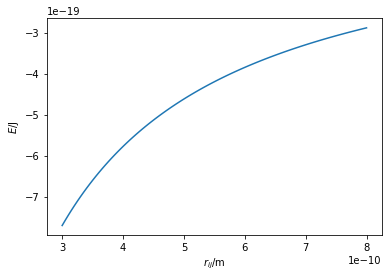

In [2]:
%matplotlib inline
from scipy.constants import e, epsilon_0
from math import pi

def Coulomb(qi, qj, dr):
    return (qi * qj * e ** 2.) / (4. * pi * epsilon_0 * dr)

r = np.linspace(3e-10, 8e-10, 100)
plt.plot(r, Coulomb(1, -1, r))
plt.xlabel(r'$r_{ij}$/m')
plt.ylabel(r'$E$/J')
plt.show()

Note that if $q_i$ and $q_j$ have different signs (e.g. are oppositely charged) then the value of $E_{\text{Coulomb}}$ will **always** be less then zero (e.g. attractive). It is clear that this mathematical function has clear roots in the physics of the system. 

However, the other component of the non-bonded interaction is less well defined. This is the **van der Waals** interaction, which encompasses both the attractive London dispersion effects and the repulsive Pauli exclusion principle. There are a variety of ways that the van der Waals interaction can be modelled, this week we will investigate a few of these. 

One commonly applied model is the **Lennard-Jones** potential model, which considers the attractive London dispersion effects as follows, 

$$ E_{\text{attractive}}(r_{ij}) = \frac{-B}{r_{ij}^6}, $$

where $B$ is some constant for the interaction, and $r_{ij}$ is the distance between the two atoms. The Pauli exclusion principle is repulsive and only presented over very short distances, and is therefore modelled with the relation, 

$$ E_{\text{repulsive}}(r_{ij}) = \frac{A}{r_{ij}^{12}}, $$

again $A$ is some interaction specific constant. The total Lennard-Jones interaction is then the linear combination of these two terms, 

$$ E_{LJ}(r_{ij}) = E_{\text{repulsive}}(r_{ij}) + E_{\text{attractive}}(r_{ij}) = \frac{A}{r_{ij}^{12}} - \frac{B}{r_{ij}^6}. $$

As was performed for the electrostatic interaction, in the cell below **define** each of the attractive, repulsive and total van der Waals interaction energies as defined by the Lennard-Jones potential and plot **all three** on a single graph, where $A = 1.363\times10^{-134}\text{ Jm}^{-12}$ and $B = 9.273\times10^{-78}\text{ Jm}^{-6}$.

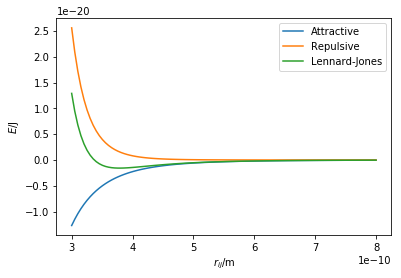

In [3]:
%matplotlib inline
def attractive(dr, b):
    return -b / np.power(dr, 6)

def repulsive(dr, a):
    return a / np.power(dr, 12)

def lj(dr, constants):
    return repulsive(dr, constants[0]) + attractive(dr, constants[1])

r = np.linspace(3e-10, 8e-10, 100)
plt.plot(r, attractive(r, 9.273e-78), label='Attractive')
plt.plot(r, repulsive(r, 1.363e-134), label='Repulsive')
plt.plot(r, lj(r, [1.363e-134, 9.273e-78]), label='Lennard-Jones')
plt.xlabel(r'$r_{ij}$/m')
plt.ylabel(r'$E$/J')
plt.legend()
plt.show()

In [4]:
np.testing.assert_almost_equal(attractive(5e-10, 9.273e-78) * 1e18, -5.93472e-4)
np.testing.assert_almost_equal(repulsive(5e-10, 1.363e-134) * 1e18, 5.5828e-5)
np.testing.assert_almost_equal(lj(5e-10, [1.363e-134, 9.273e-78]) * 1e18, -5.3764e-4)

The Lennard-Jones potential is by no means the only way to model the van der Waals interaction. Another common potential model is the **Buckingham** potential, like the Lennard-Jones potential, the Buckingham models the attractive term with a power-6. However, instead of the power-12 repulsion, this is modelled with an exponential function. The total Buckingham potential is as follows, 

$$ E_{\text{Buckingham}}(r_{ij}) = A\exp{-Br_{ij}} - \frac{C}{r_{ij}^6}, $$

where $A$, $B$, and $C$ are interaction specific. N.B. these are not the same $A$ and $B$ as in the Lennard-Jones potential. 

**In the cell below**, define a Buckingham potential and plot it, where $A = 1.69\times10^{-15}\text{ J}$, $B = 3.66\times10^{10}\text{ m}$, and $C = 1.02\times10^{-77}\text{ Jm}^{-6}$.

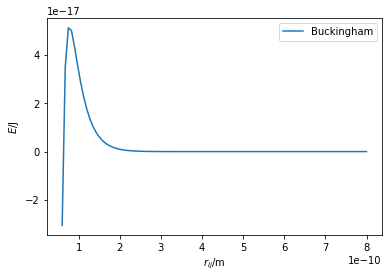

In [5]:
%matplotlib inline
def buckingham(dr, constants):
    return constants[0] * np.exp(-constants[1] * dr) - constants[2] / np.power(dr, 6)

r = np.linspace(0.6e-10, 8e-10, 100)
plt.plot(r, buckingham(r, [1.69e-15, 3.66e10, 1.02e-77]), label='Buckingham')
plt.xlabel(r'$r_{ij}$/m')
plt.ylabel(r'$E$/J')
plt.legend()
plt.show()

In [6]:
np.testing.assert_almost_equal(buckingham(5e-10, [1.69e-15, 3.66e10, 1.02e-77]) * 1e18, -6.3373e-4)
np.testing.assert_almost_equal(buckingham(0.5e-10, [1.69e-15, 3.66e10, 1.02e-77]) * 1e15, -.381701)

When the Buckingham potential is plotted from $3~Å$ to $10~Å$, the potential looks similar to the Lennard-Jones. There is a well of ideal interatomic distance with a shallow path out as the particles move apart and a very steep incline for the particles to move closer. Now **investigate** the Buckingham potential over the range of $0.6~Å$ and $8~Å$ and comment on the interaction when $r_{ij} < 0.75~Å$. Does this appear physically realistic? **Comment** on problems that may occur when the Buckingham potential is being used at very high temperature. 

Comment on the problems that may occur when the Buckingham potential is being used at very high temperature.

### More simplifications

The classical methods that involve modelling atoms as a series of particles with analytical mathematical functions to describe their energy is currently regularly used to model the properties of very large systems, like biological macromolecules. While these calculations are a lot faster using classical methods than quantum mechanics, for a system with $10 000$ atoms, there are still nearly $50 000 000$ interactions to consider. Therefore, so that our calculation run on a feasible timescale we make use of some additional simplifications. 

#### Cut-offs

If we plot the Lennard-Jones potential all the way out to $15 Å$, we get something that looks like *Figure 2*. 

<center>
    <br>
    <img src="./figures/fig002.png" width="400px">
    <i>Figure 2. The Lennard-Jones potential (blue) and a line of y=0 (orange).</i>
    <br>
</center>

It is clear from *Figure 2*, and from our understanding of the particle interaction, that as the particle move away from each other their interaction energy tends towards $0$. The concept of a cut-off suggests that if to particles are found to be very far apart ($\sim15~Å$), there is no need calculate the energy between them and it can just be taken as $0$, 

$$       E(r_{ij})=\left\{
  \begin{array}{@{}ll@{}}
    \dfrac{A}{r_{ij}^{12}} - \dfrac{B}{r_{ij}^6}, & \text{if}\ a<15\text{ Å} \\
    0, & \text{otherwise.}
  \end{array}\right.
$$

This saves significant computation time, as power (e.g. power-12 and power-6 in the Lennard-Jones potential) are very computationally expensive to calculate. 

In the cell below, **modify** your Lennard-Jones and Buckingham potential functions to have a cut-off of $15 Å$ (for this you will need to recall if and else statements from the previous Python labs).

In [7]:
def lj(dr, constants):
    if dr < 15e-10:
        return repulsive(dr, constants[0]) + attractive(dr, constants[1])    
    else:
        return 0   

def buckingham(dr, constants):
    if dr < 15e-10:
        return constants[0] * np.exp(-constants[1] * dr) - constants[2] / np.power(dr, 6)
    else:
        return 0

In [8]:
np.testing.assert_almost_equal(lj(5e-10, [1.363e-134, 9.273e-78]) * 1e18, -5.3764e-4)
np.testing.assert_almost_equal(buckingham(5e-10, [1.69e-15, 3.66e10, 1.02e-77]) * 1e18, -6.3373e-4)
np.testing.assert_almost_equal(buckingham(0.5e-10, [1.69e-15, 3.66e10, 1.02e-77]) * 1e15, -.381701)
np.testing.assert_equal(lj(15e-10, [1.363e-134, 9.273e-78]) * 1e18, 0)
np.testing.assert_equal(buckingham(15e-10, [1.69e-15, 3.66e10, 1.02e-77]) * 1e18, 0)

#### Periodic boundary conditions

Even with cut-offs, it is not straightforward to design a large enough simulation cell to represent the bulk behaviour of liquids or solids in a physically relevant way, for example what happens when the atoms interact with the walls of the cell? This is dealt with using **periodic boundary conditions**, which state that the cell being simulated is part of an infinite number of identical cells arranged in a lattice (*Figure 3*). 

<center>
    <br>
    <img src="./figures/fig003.png" width="300px">
    <i>Figure 3. A two-dimensional example of a periodic cell.</i>
    <br>
</center>

When a particle reaches the cell wall, it moves into the adjecent cell, and since all the cells are identical, it appears on the other side. **Run** the cell below to see a periodic boundary condition in action for a single cell. 

<IPython.core.display.Javascript object>


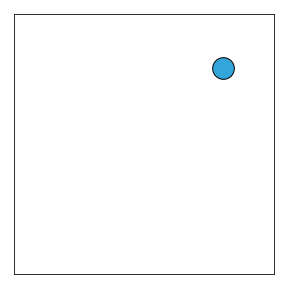

<IPython.core.display.Javascript object>


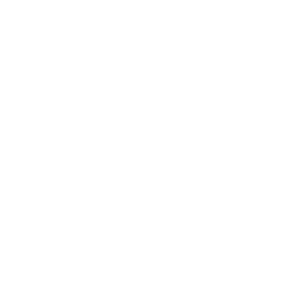

In [9]:
%matplotlib notebook
examples.pbc()

### Molecular dynamics

Having introduced the classical methods, it is now necessary to discuss how the **dynamics of molecules** are obtained. The particles that we are studying are classical in nature, therefore it is possible to apply classical mechanics to rationalise their dynamical behaviour. For this the starting point is Newton's second law of motion, 

$$ \mathbf{f} = m\mathbf{a}, $$ 

where, $\mathbf{f}$ is the force on an atom of mass, $m$, and acceleration, $\mathbf{a}$. The force between two particles, $i$ and $j$, can be found from the interaction energy, 

$$ f_{ij} = \frac{-\text{d}E(r_{ij})}{\text{d}r_{ij}}. $$  

Which is to say that the force is the negative of the first derivative of the energy with respect to the distance between them. In the cell below, a new function has been defined for the Buckingham energy **or** force. 

In [10]:
def buckingham(dr, constants, force):
    if force:
        return constants[0] * constants[1] * np.exp(-constants[1] * dr) - 6 * constants[2] / np.power(dr, 7)
    else:
        return constants[0] * np.exp(-constants[1] * dr) - constants[2] / np.power(dr, 6)

Use the above function as a template to **define** a similar function to determine the energy **or** force from the Buckingham potential. 

In [11]:
def lennard_jones(dr, constants, force):
    if force:
        return 12 * constants[0] * np.power(dr, -13) - (6 * constants[1] * np.power(dr, -7))
    else:
        return constants[0] * np.power(dr, -12) - (constants[1] * np.power(dr, -6))

In [12]:
np.testing.assert_almost_equal(lennard_jones(5e-10, [1.363e-134, 9.273e-78], False) * 1e18, -5.3764e-4)
np.testing.assert_almost_equal(lennard_jones(5e-10, [1.363e-134, 9.273e-78], True) * 1e10, -5.78178e-2)
np.testing.assert_almost_equal(lennard_jones([5e-10, 5e-10], [1.363e-134, 9.273e-78], True) * 1e10, 
                               [-5.78178e-2, -5.78178e-2])

You may have noted that the force in eqn. 8 is a vector quantity, whereas that in eqn. 9 is not. Therefore it is necessary to convert obtain the force vector in each dimension, by multiplication by the unit vector in that dimenion, 

$$ \mathbf{f}_x = f \mathbf{\hat{r}}_x \text{, where } \mathbf{\hat{r}}_x = \frac{r_x}{|\mathbf{r}|}. $$

This must be carried out to determine the force on the particle in each dimension that is being considered. However, in this example we will only consider the $x$-dimension for now.

This means for a system with two argon particles, at positions of $x_0 = 5~Å$ and $x_1 = 10~Å$, we are able to determine the energy of the interaction and force, and acceleration on each particle, as **shown** in the cell below.

In [13]:
mass_of_argon = 39.948 # amu
mass_of_argon_kg = mass_of_argon * 1.6605e-27

def get_acceleration(positions):
    rx = np.zeros_like(positions)
    k = 0
    for i in range(0, len(positions)):
        for j in range(0, len(positions)):
            if i != j:
                rx[k] = positions[i] - positions[j]
                k += 1
    r_mag = np.sqrt(rx * rx)
    force = lennard_jones(r_mag, [1.363e-134, 9.273e-78], True)
    force_x = force * rx / r_mag
    acceleration_x = force_x / mass_of_argon_kg
    return acceleration_x

positions = np.array([5e-10, 10e-10])
acc = get_acceleration(positions)
print('acceleration on particle 0 = {:.2e} m/s2'.format(acc[0]))
print('acceleration on particle 1 = {:.2e} m/s2'.format(acc[1]))

acceleration on particle 0 = 8.72e+13 m/s2
acceleration on particle 1 = -8.72e+13 m/s2


#### Integration

This means that we now know the position of the particle and the acceleration that it has, so it is only necessary to then find the velocity of the particle and we can apply the basic equations of motion to our particles,

$$ \mathbf{x}_i(t + \Delta t) = \mathbf{x}_i(t) + \mathbf{v}_i(t)\Delta t + \dfrac{1}{2} \mathbf{a}_i(t)\Delta t^2, $$

$$ \mathbf{v}_i(t + \Delta t) = \mathbf{v}_i(t) + \dfrac{1}{2}\big[\mathbf{a}_i(t) + \mathbf{a}_i(t+\Delta t)\big]\Delta t, $$ 

where, $\Delta t$ is the timestep (how far in time is incremented), $\mathbf{x}_i$ is the particle position, $\mathbf{v}_i$ is the velocity, and $\mathbf{a}_i$ the acceleration. This pair of equations is known as the Velocity-Verlet algorithm, which can be written as:

1. find the position of the particle after some timestep using eqn. 11, 
2. calculate the force (and acceleration) on the particle,
3. determine a new velocity for the particle, based on the average acceleration at the current and new positions, using eqn. 12, 
4. overwrite the old acceleration values with the new ones, $\mathbf{a}_{i}(t) = \mathbf{a}_{i}(t + \Delta t)$,
4. go to 1.

This process can be continued for as long as is required to get good statistics for the quanity you are interested in (or for as long as you can wait for/afford to run the computer for).  

This process is called the integration step, and the Velocity-Verlet is the **integrator**. The Velocity-Verlet integration is numerical in nature, meaning that the accuracy of this method is dependent on the timestep, $\Delta t$, size. Small values of $\Delta t$ are capable of keeping the resultant uncertainty of the position and velocity small, these values are usually on the scale of $10^{-15}\text{ s}$ (femtoseconds). This means that to even measure a nanosecond of "real-time" molecular dynamics, 1 000 000 (one million) iterations of the above algorithm must be performed. 

In the cell below, these have been defined. 

In [14]:
def update_pos(x, v, a, dt):
    return x + v * dt + 0.5 * a * dt * dt

def update_velo(v, a, a1, dt):
    return v + 0.5 * (a + a1) * dt

#### Initialisation

There are only two tools left that you need to run a molecular dynamics simulation, and both are associated with the original configuration of the system; the original particle positions, and the original particle velocities. 

The particle positions are usually taken from some library of structures (e.g. the protein data bank if you are simulating proteins) or based on some knowledge of the system (e.g. CaF<sub>2</sub> is known to have a face-centred cubic structure). The particle velocities are a bit more nuanced, as the total kinetic energy, $E_K$ of the system (and therefore the particle velocities) are dependent on the temperature of the simulation, $T$. 

$$ E_K = \sum_{i=1}^N \frac{m_i|v_i|^2}{2} = \frac{3}{2}Nk_BT, $$

where $m_i$ is the mass of particle $i$, $N$ is the number of particles and $k_B$ is the Boltzmann constant. Based on this knowledge, the most common way to obtain initial velocities is to assign random values and then scale them based on the temperature of the system. For example, in the software you will use later today the initial velocity are determined as follow, 

$$ v_i = R_i \sqrt{\dfrac{k_BT}{m_i}}, $$

where $R_i$ is some random number between $-0.5$ and $0.5$, $k_B$ is the Boltzmann constant, $T$ is the temperature, and $m_i$ is the mass of the particle.

In the cell below, **define** a function to generate an initial velocity for an arbitrary number of particles.

In [15]:
def init_velocity(temperature, part_numb):
    v = np.random.rand(part_numb) - 0.5
    return v * np.sqrt(temperature * 1.3806e-23 / mass_of_argon_kg)

#### Build an MD simulation

We will now try and use what we have done so far to build a 1-dimensional molecular dynamics simulation.

In [16]:
dt = 1e-14 # (seconds) 
number_of_steps = 1000
distances = []
# initialisation
x = np.array([5e-10, 10e-10]) # (meters) these are the starting positions of the particles
v = init_velocity(30, 2)
a = get_acceleration(x)
for i in range(0, number_of_steps):
    x = update_pos(x, v, a, dt)
    a1 = get_acceleration(x)       
    v = update_velo(v, a, a1, dt)
    a = np.array(a1)
    distances.append(np.abs(x[1] - x[0]))


**Ensure** that a demonstrator has checked the MD simulation before you continue!

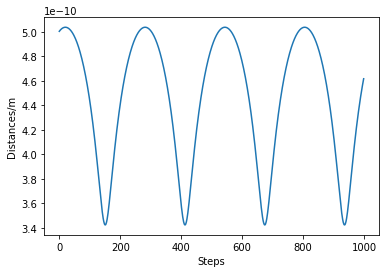

In [17]:
%matplotlib inline
plt.plot(distances)
plt.xlabel('Steps')
plt.ylabel('Distances/m')
plt.show()

Run your 1-D molecular dynamics simulation a few times each at a range of different initial temperatures. In the cell below, **comment** on the effect of the different temperature on the distances that are sampled in the simulation.

Comment on the effect of the different temperature on the interatomic distances sampled in the simulation

## Phase diagram

Having been introduced to the main aspects of the molecular dynamics simulation methodlogy, we will make use of existing software packages to probe material structure. This is common pratice, as writing a full software package is very complicated, so it is best to use a *well-troden*, and optimised, code.

This week you will make use of the pylj [1] code, which simulates argon atoms in a 2-dimensional environment. Next week, you will be introduced to DLPOLY [2], a more general purpose molecular dynamics package. 

Before we introduce how to use the pylj software, it is necessary to consider the problem to which it will be applied,

> The aim of the rest of this session is to determine and plot the phase diagram for two-dimension argon

The determination of a material's phase on the atomistic scale is a non-trivial task. In this exercise, we will use two main tools for phase identification:

- Mean squared displacement (MSD)
- Radial distribution function (RDF) 

### Mean squared displacement

You will find out more about the MSD next week. However, for now we only need to be aware the MSD is a measure of how far the particles have moved during the simulation. The result is that it is possible to identify different phase of matter from the MSD plot, see *Figure 4* below. 

<center>
    <br>
    <img src="./figures/fig004.png" width="400px">
    <i>Figure 4. The anticipated MSD form for each state of matter.</i>
    <br>
</center>

It should be expected that in a simulation of a given time, gaseous particles will be able to travel further than liquids, which can travel further then solids. 

### Radial distribution function

A radial distribution function is the probability that another atom would be found at a given distance from each atom, and is a very useful measure of order in the system, of-course more disorder means more gas-like. Shown in *Figure 5*, are the RDFs for three materials; consider the shape of each one and the amount of **order** represented, in the cell below **comment on** and **explain** the expected state (solid, liquid or gas) for each. 

<center>
    <br>
    <img src="./figures/fig005.png" width="800px">
    <i>Figure 5. The radial distribution functions for 3 states of matter .</i>
    <br>
</center>

### Software

[pylj](http://pythoninchemistry.org/pylj) (python Lennard-Jones) [1] is an open-source Python package for producing molecular dynamics simulations of argon particles (interacting through the Lennard-Jones potential) in 2-dimensions. 

In the cell below, a molecular dynamics algorithm is **defined** using the pylj library. **Run this cell as is.**

In [24]:
from pylj import md, sample

def md_simulation(temperature, number_of_particles, number_of_steps, ff, parameters):
    # Creates the visualisation environment
    %matplotlib notebook
    # Initialise the system
    system = md.initialise(number_of_particles, temperature, 20, 'square', forcefield=ff, constants=parameters)
    # This sets the sampling class
    sample_system = sample.Phase(system)
    # Start at time 0
    system.time = 0
    # Begin the molecular dynamics loop
    for i in range(0, number_of_steps):
        # Run the equations of motion integrator algorithm, this 
        # includes the force calculation
        system.integrate(md.velocity_verlet)
        # Sample the thermodynamic and structural parameters of the system
        system.md_sample()
        # Allow the system to interact with a heat bath
        system.heat_bath(temperature)
        # Iterate the time
        system.time += system.timestep_length
        system.step += 1
        # At a given frequency sample the positions and plot the RDF
        if system.step % 25 == 0:
            sample_system.update(system)
    sample_system.average()
    return system, sample_system

Having defined the molecular dynamics function, we can run it below. 

The variables that this function takes are as follows:

- temperature (K)
- number of particles
- number of simulation steps
- forcefield

Running this function will result in four panels being presented. The top left shows the particles in the simulation, the top right gives the total energy for the system, the bottom left is the mean squared displacement and bottom right is the radial distribution function. 

<IPython.core.display.Javascript object>


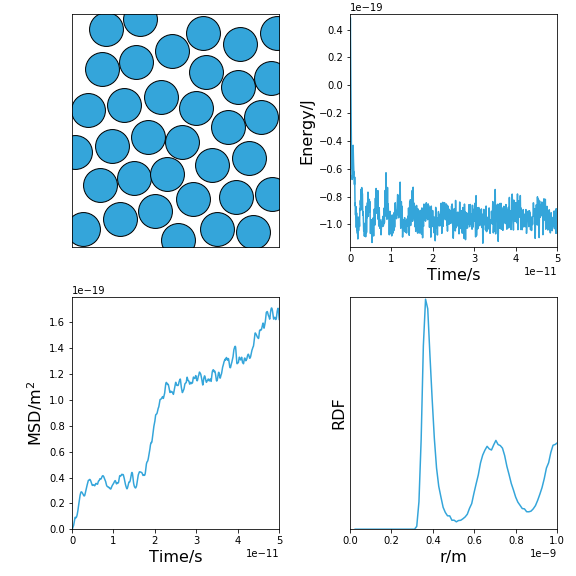

In [26]:
sim, samp_sim = md_simulation(temperature=100, 
                              number_of_particles=35, 
                              number_of_steps=5000, 
                              ff=buckingham, 
                              parameters=[1.69e-15, 3.66e10, 1.02e-77])

<IPython.core.display.Javascript object>


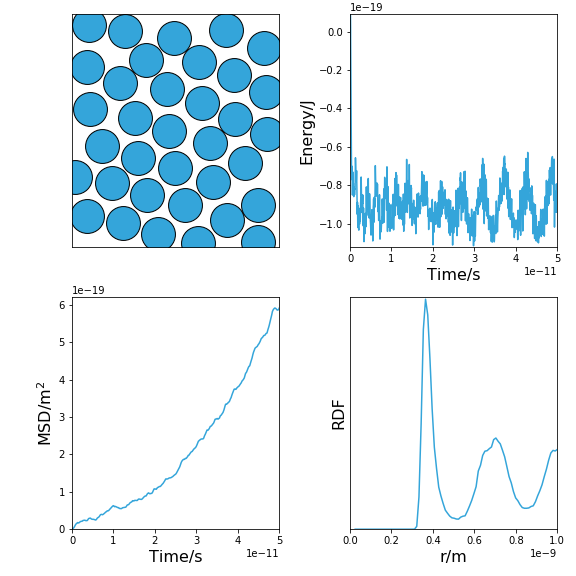

In [27]:
sim, samp_sim = md_simulation(temperature=100, 
                              number_of_particles=35, 
                              number_of_steps=5000, 
                              ff=lennard_jones, 
                              parameters=[1.363e-134, 9.273e-78])

### Plotting a phase diagram 

A phase diagram should be familiar from first-year, this is a graphical representation of the physical state of a substance under different conditions of state such as temperature, pressure and density. 

In this exercise the two variables will be temperature and density (by controlling the number of particles). Using the information that pylj returns about the MSD and the RDF determine the phase for a range of values of temperature (T) and number of particles (N). If the system is a solid, place the pair of T and N in the `solid` array, and similar for if the system is a liquid or a gas. Be aware that if the system is not yet at **equilibrium** (e.g. the energy has not minimised) then the data may not be reliable, make sure you run your simulations for long enough!

In [20]:
solid_N = np.array([□ □ □])
solid_T = np.array([□ □ □])
liquid_N = np.array([□ □ □])
liquid_T = np.array([□ □ □])
gas_N = np.array([□ □ □])
gas_T = np.array([□ □ □])

fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(solid_T, solid_N, 'o', c='#0173B2')
plt.plot(liquid_T, liquid_N, 'o', c='#DE8F05')
plt.plot(gas_T, gas_N, 'o', c='#029E73')
plt.xlabel('temperature/K')
plt.ylabel('number')
plt.show()

SyntaxError: invalid character in identifier (<ipython-input-20-0819496ce1ec>, line 1)

# References

1. A. R. McCluskey, B. J. Morgan, K. J. Edler, and S. C. Parker, (2018). pylj: A teaching tool for classical atomistic simulation. JOSS, **1**(2), 19, https://doi.org/10.21105/jose.00019
2. W. Smith and T. R. Forester, (1996). DL_POLY_2.0: A general-purpose parallel molecular dynamics simulation package. J Mol. Graph. Model. **14**, 136-141, https://doi.org/10.1016/S0263-7855(96)00043-4